In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random

In [2]:
maze_size = 13
wall = [(5,5), (5,7), (6,5), (6,7), (7,5), (7,6), (7,7)]

In [3]:
def populate_maze(posb, posc, maze_size):
    grid_world = np.full((maze_size, maze_size),0)
    grid_world = np.asmatrix(grid_world)
    grid_world.itemset(posb, 2)
    grid_world.itemset(posc, 4)
    walls = [(5,5), (5,7), (6,5), (6,7), (7,5), (7,6), (7,7)]
    for i in walls:
        grid_world.itemset(i, 1)
    return grid_world

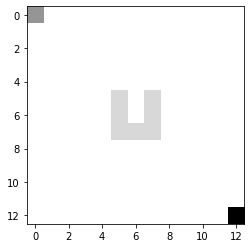

In [4]:
grid = populate_maze((0,0), (maze_size-1, maze_size-1), maze_size)
colormap = cm.get_cmap("Greys")
plt.imshow(grid, cmap=colormap)

In [5]:
def neighbors(entity, position, maze_size):
    x = position[0]
    y = position[1]

    if entity == 'bull':
        allChildren = [(x+1,y),#down
               (x-1,y),#up
               (x,y+1),#right
               (x,y-1)]#left
        if x+1 > maze_size-1:
            allChildren.remove((x+1,y))
        if x-1 < 0:
            allChildren.remove((x-1,y))
        if y+1 > maze_size-1:
            allChildren.remove((x,y+1))
        if y-1 < 0:
            allChildren.remove((x,y-1)) 

    elif entity == 'robot':
        allChildren = [(x+1,y),#down
               (x-1,y),#up
               (x,y+1),#right
               (x,y-1),#left
               (x+1,y+1),#bottom right
               (x+1,y-1),#bottom left
               (x-1,y+1),#top right
               (x-1,y-1)]# top left

        if x+1 > maze_size-1:
            allChildren.remove((x+1,y))
            allChildren.remove((x+1,y+1))
            allChildren.remove((x+1,y-1))
        if x-1 < 0:
            allChildren.remove((x-1,y))
            allChildren.remove((x-1,y+1))
            allChildren.remove((x-1,y-1))
        if y+1 > maze_size-1:
            allChildren.remove((x,y+1))
            if (x-1,y+1) in allChildren:
                allChildren.remove((x-1,y+1))
            if (x+1,y+1) in allChildren:
                allChildren.remove((x+1,y+1))
        if y-1 < 0:
            allChildren.remove((x,y-1))
            if (x-1,y-1) in allChildren:
                allChildren.remove((x-1,y-1))
            if (x+1,y-1) in allChildren:
                allChildren.remove((x+1,y-1))
    return allChildren

In [6]:
def manhattan_distance_calc(state):
    """
    This function returns manhattan distance for every cell
    i: row value
    j: column value
    n: size of the maze
    """
    return abs(state[0] -  state[2]) + abs(state[1] - state[3])

In [7]:
def update_Q(current_state, Q, bull_neighbors, robot_neighbors):
    probability_bull = 1/len(bull_neighbors)
    probability_robot = 1/len(robot_neighbors)
    beta = 0.9
    reward = 1
    max_q_value = -999

    for state in Q[current_state].keys():
        q_value = reward + beta * probability_robot * probability_bull * Q[current_state][state]
        Q[current_state][state] = q_value
    return Q

In [9]:
def states_generator(maze_size):
    A = {}

    for i in range(maze_size):
        for j in range(maze_size):
            for k in range(maze_size):
                for l in range(maze_size):
                        A[(i,j,k,l)] = {}
                        A[(i,j,k,l)][(i,j,k,l)] = -1

    for i in A.keys():
        robot_neighbors = neighbors('robot', i[2:4], maze_size)
        bull_neighbors = neighbors('bull', i[:2], maze_size)
        for m in robot_neighbors:
            for n in bull_neighbors:
                A[i][n+m] = -1

    for i in range(maze_size-1):
        for j in range(maze_size-1):
            A[(5,6,i,j)] = {}
            A[(5,6,i,j)][(6,6,i,j)] = 1000

    for cell in [(5,5), (5,7), (6,5), (6,7), (7,5), (7,6), (7,7)]:
        A[cell+(k,l)] = -100
        A[(i,j) + cell] = -100

    return A

# Compute Q values

In [10]:
def compute_qvalues(bull, robot):
    Q = states_generator(maze_size)
    x = (6,6)
    walls = [(5,5), (5,7), (6,5), (6,7), (7,5), (7,6), (7,7)]
    visited_list = []
    
    while bull != x:
        robot_neighbors = neighbors('robot', robot, maze_size)
        bull_neighbors = neighbors('bull', bull, maze_size)
        current_state = bull + robot
        minimum_manhattan_distance = 999
        visited_list.append(current_state)
        if current_state not in Q.keys():
            Q[current_state] = {}

        if manhattan_distance_calc(current_state) <= 3:
            min_distance_between_x_and_robot = 999
            min_distance_between_bull_and_robot = 999
            distance_between_x_and_robot = 0

            for robot_neighbor in robot_neighbors:
                distance_between_x_and_robot = manhattan_distance_calc(robot_neighbor + x)
                if min_distance_between_x_and_robot > distance_between_x_and_robot:
                    min_distance_between_x_and_robot = distance_between_x_and_robot
                    robot = robot_neighbor
                    if robot[0] < x[0] and robot[1] > x[1]:
                        # top right to x
                        distance_between_x_and_robot = manhattan_distance_calc((6,8) + robot)
                    elif robot[0] < x[0] and robot[1] < x[1]:
                        # top left to x
                        distance_between_x_and_robot = manhattan_distance_calc((6,4) + robot)
                    elif robot[0] > x[0] and robot[1] > x[1]:
                        # bottom right to x
                        distance_between_x_and_robot = manhattan_distance_calc((4,8) + robot)
                    elif robot[0] > x[0] and robot[1] > x[1]:
                        # bottom left to x
                        distance_between_x_and_robot = manhattan_distance_calc((4,4) + robot)

                    if distance_between_x_and_robot < min_distance_between_x_and_robot:
                        robot = robot_neighbor

                while robot == x:
                    random_index = random.randint(0, len(robot_neighbors) - 1)
                    robot = robot_neighbors[random_index]
                    
            for bull_neighbor in bull_neighbors:
                distance_between_bull_and_robot = manhattan_distance_calc(bull_neighbor + robot)
                if distance_between_bull_and_robot < min_distance_between_bull_and_robot:
                    min_distance_between_bull_and_robot = distance_between_bull_and_robot
                    bull = bull_neighbor
        else:
            for bull_neighbor in bull_neighbors:
                for robot_neighbor in robot_neighbors:
                    neighboring_state = bull_neighbor + robot_neighbor

                    if neighboring_state not in Q[current_state].keys():
                        Q[current_state][neighboring_state] = -1

                    distance = manhattan_distance_calc(neighboring_state)
                    if minimum_manhattan_distance > distance:
                        minimum_manhattan_distance = distance
                        next_state = neighboring_state
                        Q[current_state][next_state] += 5
            
            random_index = random.randint(0, len(bull_neighbors) - 1)
            bull = bull_neighbors[random_index]
            robot = (next_state[2:4])
            Q[current_state][bull + robot] += 10
            
        while robot == bull or (robot in walls):
            random_index = random.randint(0, len(robot_neighbors) - 1)
            robot = robot_neighbors[random_index]
        while bull in walls:
            random_index = random.randint(0, len(bull_neighbors) - 1)
            bull = bull_neighbors[random_index]
        Q = update_Q(current_state, Q, bull_neighbors, robot_neighbors)
    return Q, visited_list

In [11]:
bull = (0,0)
robot = (maze_size-1, maze_size-1)

Q, visited_list = compute_qvalues(bull, robot)

# T*

In [12]:
bull = (0,0)
robot = (maze_size-1,maze_size-1)
x = (6,6)


def t_star(bull, robot, visited_list, x):
    visited_list = []
    iteration = 0
    while bull != x:

        iteration += 1
        current_state = bull + robot

        if current_state not in visited_list:
            visited_list.append(current_state)

        for neighbor_state in Q[current_state]:
            # if all the states have same Q value
            if len(list(set(list(Q[current_state].values())))) == 1:
                entry_list = list(Q[current_state].items())
                next_state = random.choice(entry_list)[0]
            else:
                # the next state is chosen with max_q value
                next_state = max(Q[current_state], key=Q[current_state].get)

        bull = next_state[:2]
        robot = next_state[2:4]

    print('The minimal expected movements taken is:', iteration)

In [13]:
t_star(bull, robot, visited_list, x)

The minimal expected movements taken is: 43
